In Model M1 we made a customer churn prediction with the help of XGboost in which kilometer_cleaned where induted with the help of Xgboost, 
In Model M2 Customer churn will be predicted without  intuting and with missing values of Kilometer_clean. 
Inm Model M3 we will predict customer churn with the help of XGboost and with the help of missing  kilometer_cleane values.  

In [1]:
#importing all required python librabries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
import optuna 

d:\IV_Mastertheis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df= pd.read_csv('D:\IV_Mastertheis\df_missing_kilometerstand.csv')


<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\VIP\AppData\Local\Temp\ipykernel_11644\723158826.py:1: SyntaxWarning: invalid escape sequence '\I'
  df= pd.read_csv('D:\IV_Mastertheis\df_missing_kilometerstand.csv')
C:\Users\VIP\AppData\Local\Temp\ipykernel_11644\723158826.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('D:\IV_Mastertheis\df_missing_kilometerstand.csv')


In [5]:
df['Dura_in_yrs'] = df['vtr_dau'] // 365
df = df[df['carage_years'] < 13]
columns_needed = [
    "vsnr",'aktiv', "vtr_dau","Dura_in_yrs", "vtrweg", "SDANZAHL", "SCHAGESA", "KOSTGESA",
    "kosten_verw", "kosten_prov", "alter", "ELEKTRO", "KILOMETERSTAND_CLEAN",
    "claim", "beg_year", "beg_month", "Quarter", "Weekday_id", "Cus_typ_id",
    "ort_id", "gender_id", "plz_id", "Hersteller_id", "state_id", "TSN_id",
    "estimated_total_paid",'spartek','carage_years','Car_age_indays']

df_imp= df[columns_needed]

In [6]:
# PART 1: SETUP AND DATA PREPARATION
# Run this first to set up your data

import pandas as pd
import numpy as np
import optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, accuracy_score
from xgboost import XGBClassifier

# ✅ 1. Select features and target
selected_features = [ 
    "estimated_total_paid",
    "carage_years",
    "kosten_verw", 
    "kosten_prov", 
    "alter", 
    "KILOMETERSTAND_CLEAN", 
    "claim",
    "state_id",
    "plz_id",
    "Cus_typ_id"
]
target = 'aktiv'

print("🚀 Starting Enhanced XGBoost Training with Optuna")
print(f"📊 Features: {len(selected_features)}")
print(f"🎯 Target: {target}")

# ✅ 2. Prepare data
df_model = df_imp[selected_features + [target]].dropna()
print(f"📈 Dataset shape after cleaning: {df_model.shape}")
print(f"🎲 Target distribution:\n{df_model[target].value_counts(normalize=True)}")

X = df_model[selected_features]
y = df_model[target]

# ✅ 3. Split data strategically
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.11, random_state=42, stratify=y_temp
)

print(f"📊 Data splits:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Validation: {X_val.shape[0]} samples") 
print(f"   Test: {X_test.shape[0]} samples")



🚀 Starting Enhanced XGBoost Training with Optuna
📊 Features: 10
🎯 Target: aktiv
📈 Dataset shape after cleaning: (877729, 11)
🎲 Target distribution:
aktiv
0    0.504453
1    0.495547
Name: proportion, dtype: float64
📊 Data splits:
   Training: 703060 samples
   Validation: 86896 samples
   Test: 87773 samples


In [7]:
# ✅ 4. Enhanced Optuna objective function
def objective(trial):
    """
    Enhanced objective function with regularization focus to combat overfitting
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 8),  # Reduced to combat overfitting
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),  # Regularization
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 3),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 3),  # L2 regularization
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),  # Prevent overfitting
        'use_label_encoder': False,
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }
    
    # Use cross-validation for robust evaluation
    model = XGBClassifier(**params)
    cv_scores = cross_val_score(
        model, X_train, y_train, 
        cv=3,  # 3-fold CV for speed
        scoring='f1',
        n_jobs=-1
    )
    
    return cv_scores.mean()

# ✅ 5. Run Optuna optimization with progress tracking
def print_callback(study, trial):
    """Callback to print progress"""
    print(f"⚡ Trial {trial.number:3d}: F1 = {trial.value:.4f} | Best = {study.best_value:.4f}")

print("\n🔍 Starting hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

n_trials = 50  

study.optimize(
    objective, 
    n_trials=n_trials,
    callbacks=[print_callback],
    show_progress_bar=True
)

print(f"\n🎯 Optimization completed!")
print(f"🏆 Best F1-Score: {study.best_value:.4f}")
print(f"📋 Best Parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

print("✅ Part 2 completed! Best parameters found.")

[I 2025-06-19 11:12:04,989] A new study created in memory with name: no-name-b2dec54d-94da-4abd-a2c0-d0bd8a047ed4



🔍 Starting hyperparameter optimization...


Best trial: 0. Best value: 0.830964:   2%|▏         | 1/50 [00:23<18:51, 23.10s/it]

[I 2025-06-19 11:12:28,089] Trial 0 finished with value: 0.8309638162742147 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.14907884894416698, 'subsample': 0.779597545259111, 'colsample_bytree': 0.6468055921327309, 'gamma': 0.3119890406724053, 'reg_alpha': 0.2684424752877784, 'reg_lambda': 2.665440364437338, 'min_child_weight': 7}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   0: F1 = 0.8310 | Best = 0.8310


Best trial: 0. Best value: 0.830964:   4%|▍         | 2/50 [00:40<15:58, 19.96s/it]

[I 2025-06-19 11:12:45,860] Trial 1 finished with value: 0.8077103347142848 and parameters: {'n_estimators': 383, 'max_depth': 3, 'learning_rate': 0.19428287191077892, 'subsample': 0.8497327922401265, 'colsample_bytree': 0.6637017332034828, 'gamma': 0.36364993441420124, 'reg_alpha': 0.631873078574958, 'reg_lambda': 1.2606056073988443, 'min_child_weight': 7}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   1: F1 = 0.8077 | Best = 0.8310


Best trial: 0. Best value: 0.830964:   6%|▌         | 3/50 [00:55<13:51, 17.69s/it]

[I 2025-06-19 11:13:00,847] Trial 2 finished with value: 0.8078512741417239 and parameters: {'n_estimators': 273, 'max_depth': 4, 'learning_rate': 0.1262520499972521, 'subsample': 0.6418481581956126, 'colsample_bytree': 0.6876433945605654, 'gamma': 0.7327236865873834, 'reg_alpha': 1.4226029542294043, 'reg_lambda': 2.462939903482534, 'min_child_weight': 4}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   2: F1 = 0.8079 | Best = 0.8310


Best trial: 0. Best value: 0.830964:   8%|▊         | 4/50 [01:18<15:01, 19.60s/it]

[I 2025-06-19 11:13:23,377] Trial 3 finished with value: 0.8012796593937949 and parameters: {'n_estimators': 306, 'max_depth': 6, 'learning_rate': 0.01882557841679957, 'subsample': 0.7822634555704315, 'colsample_bytree': 0.6511572371061874, 'gamma': 0.13010318597055903, 'reg_alpha': 2.8517680580346663, 'reg_lambda': 2.9140800826863984, 'min_child_weight': 9}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   3: F1 = 0.8013 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  10%|█         | 5/50 [01:28<12:02, 16.06s/it]

[I 2025-06-19 11:13:33,145] Trial 4 finished with value: 0.8026698089053316 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.14000427503730983, 'subsample': 0.7320457481218804, 'colsample_bytree': 0.6366114704534336, 'gamma': 0.9903538202225404, 'reg_alpha': 0.19972671123413335, 'reg_lambda': 2.7733010051969553, 'min_child_weight': 5}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   4: F1 = 0.8027 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  12%|█▏        | 6/50 [01:45<12:02, 16.41s/it]

[I 2025-06-19 11:13:50,252] Trial 5 finished with value: 0.8087365181274263 and parameters: {'n_estimators': 365, 'max_depth': 4, 'learning_rate': 0.10881292402378405, 'subsample': 0.7640130838029839, 'colsample_bytree': 0.6554563366576581, 'gamma': 1.9391692555291171, 'reg_alpha': 2.347885187747232, 'reg_lambda': 2.848747353910473, 'min_child_weight': 10}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   5: F1 = 0.8087 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  14%|█▍        | 7/50 [02:13<14:29, 20.23s/it]

[I 2025-06-19 11:14:18,347] Trial 6 finished with value: 0.8148355088366976 and parameters: {'n_estimators': 339, 'max_depth': 8, 'learning_rate': 0.026813575389864702, 'subsample': 0.6587948587257435, 'colsample_bytree': 0.6135681866731614, 'gamma': 0.6506606615265287, 'reg_alpha': 1.227164140099498, 'reg_lambda': 1.1783725794347397, 'min_child_weight': 9}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   6: F1 = 0.8148 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  16%|█▌        | 8/50 [02:25<12:20, 17.63s/it]

[I 2025-06-19 11:14:30,400] Trial 7 finished with value: 0.8076031827236676 and parameters: {'n_estimators': 243, 'max_depth': 4, 'learning_rate': 0.1131122558000672, 'subsample': 0.6422772674924287, 'colsample_bytree': 0.8406590942262119, 'gamma': 0.14910128735954165, 'reg_alpha': 2.9619721161415002, 'reg_lambda': 2.4306119232416434, 'min_child_weight': 4}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   7: F1 = 0.8076 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  18%|█▊        | 9/50 [02:33<09:55, 14.51s/it]

[I 2025-06-19 11:14:38,061] Trial 8 finished with value: 0.8156620425104334 and parameters: {'n_estimators': 102, 'max_depth': 7, 'learning_rate': 0.14430289533104726, 'subsample': 0.8187021504122962, 'colsample_bytree': 0.8313811040057837, 'gamma': 0.14808930346818072, 'reg_alpha': 1.1395506127783905, 'reg_lambda': 0.7896726488128243, 'min_child_weight': 9}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   8: F1 = 0.8157 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  20%|██        | 10/50 [02:50<10:15, 15.39s/it]

[I 2025-06-19 11:14:55,403] Trial 9 finished with value: 0.7938014415668236 and parameters: {'n_estimators': 349, 'max_depth': 4, 'learning_rate': 0.02207608655434449, 'subsample': 0.6932946965146987, 'colsample_bytree': 0.6975549966080241, 'gamma': 1.4592123566761281, 'reg_alpha': 1.9489166669301181, 'reg_lambda': 2.7180318564408164, 'min_child_weight': 6}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial   9: F1 = 0.7938 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  22%|██▏       | 11/50 [03:19<12:48, 19.71s/it]

[I 2025-06-19 11:15:24,902] Trial 10 finished with value: 0.8283558407830501 and parameters: {'n_estimators': 478, 'max_depth': 8, 'learning_rate': 0.06846190017554982, 'subsample': 0.8796871025735362, 'colsample_bytree': 0.7564020035588104, 'gamma': 1.3804941471382906, 'reg_alpha': 0.14391828759799483, 'reg_lambda': 2.0584412965736636, 'min_child_weight': 7}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial  10: F1 = 0.8284 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  24%|██▍       | 12/50 [03:50<14:34, 23.01s/it]

[I 2025-06-19 11:15:55,458] Trial 11 finished with value: 0.8285155282758185 and parameters: {'n_estimators': 499, 'max_depth': 8, 'learning_rate': 0.06385020557104318, 'subsample': 0.8884016314330396, 'colsample_bytree': 0.7682720105447061, 'gamma': 1.4053984655159972, 'reg_alpha': 0.1319649411455889, 'reg_lambda': 1.933227444128073, 'min_child_weight': 7}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial  11: F1 = 0.8285 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  26%|██▌       | 13/50 [04:17<14:55, 24.22s/it]

[I 2025-06-19 11:16:22,455] Trial 12 finished with value: 0.8220870851331843 and parameters: {'n_estimators': 476, 'max_depth': 7, 'learning_rate': 0.0709336992077455, 'subsample': 0.8991551652098886, 'colsample_bytree': 0.7508817823256126, 'gamma': 1.4354919635399794, 'reg_alpha': 0.7009487781281151, 'reg_lambda': 1.8291707879117771, 'min_child_weight': 7}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial  12: F1 = 0.8221 | Best = 0.8310


Best trial: 0. Best value: 0.830964:  28%|██▊       | 14/50 [04:28<12:09, 20.27s/it]

[I 2025-06-19 11:16:33,621] Trial 13 finished with value: 0.821788175284023 and parameters: {'n_estimators': 171, 'max_depth': 7, 'learning_rate': 0.18656387492194187, 'subsample': 0.8192733906910248, 'colsample_bytree': 0.7952308825314209, 'gamma': 1.7618281979032513, 'reg_alpha': 0.6434086421316123, 'reg_lambda': 2.1905605214623813, 'min_child_weight': 6}. Best is trial 0 with value: 0.8309638162742147.
⚡ Trial  13: F1 = 0.8218 | Best = 0.8310


Best trial: 14. Best value: 0.850815:  30%|███       | 15/50 [04:56<13:11, 22.61s/it]

[I 2025-06-19 11:17:01,630] Trial 14 finished with value: 0.8508146264693264 and parameters: {'n_estimators': 417, 'max_depth': 8, 'learning_rate': 0.16402190794570823, 'subsample': 0.7221924822920128, 'colsample_bytree': 0.898644486900997, 'gamma': 1.0622480607029205, 'reg_alpha': 0.38595662313701007, 'reg_lambda': 1.4999517484592872, 'min_child_weight': 8}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  14: F1 = 0.8508 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  32%|███▏      | 16/50 [05:22<13:19, 23.53s/it]

[I 2025-06-19 11:17:27,299] Trial 15 finished with value: 0.8335880495596096 and parameters: {'n_estimators': 417, 'max_depth': 6, 'learning_rate': 0.16098261918129686, 'subsample': 0.7184804007034796, 'colsample_bytree': 0.885028752788897, 'gamma': 0.9792008227027074, 'reg_alpha': 0.9486881968745856, 'reg_lambda': 1.326880364704338, 'min_child_weight': 8}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  15: F1 = 0.8336 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  34%|███▍      | 17/50 [05:46<13:07, 23.85s/it]

[I 2025-06-19 11:17:51,900] Trial 16 finished with value: 0.8339373060645525 and parameters: {'n_estimators': 420, 'max_depth': 6, 'learning_rate': 0.16951246120171826, 'subsample': 0.7160255590984057, 'colsample_bytree': 0.892957264003116, 'gamma': 1.050819627026542, 'reg_alpha': 0.9981322611784773, 'reg_lambda': 1.4719229869659656, 'min_child_weight': 8}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  16: F1 = 0.8339 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  36%|███▌      | 18/50 [06:08<12:25, 23.28s/it]

[I 2025-06-19 11:18:13,868] Trial 17 finished with value: 0.8232239389357665 and parameters: {'n_estimators': 418, 'max_depth': 5, 'learning_rate': 0.1686776008493599, 'subsample': 0.6902309302018397, 'colsample_bytree': 0.8900338908395754, 'gamma': 1.1146486605928478, 'reg_alpha': 1.9195174971834064, 'reg_lambda': 1.6213912199789628, 'min_child_weight': 10}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  17: F1 = 0.8232 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  38%|███▊      | 19/50 [06:31<11:55, 23.09s/it]

[I 2025-06-19 11:18:36,515] Trial 18 finished with value: 0.823679501540445 and parameters: {'n_estimators': 418, 'max_depth': 5, 'learning_rate': 0.17715741448296846, 'subsample': 0.6004330830473851, 'colsample_bytree': 0.8518110345536751, 'gamma': 0.7278873100825659, 'reg_alpha': 1.7355266271621557, 'reg_lambda': 0.7254351323685695, 'min_child_weight': 8}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  18: F1 = 0.8237 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  40%|████      | 20/50 [06:56<11:51, 23.72s/it]

[I 2025-06-19 11:19:01,696] Trial 19 finished with value: 0.8238366885030016 and parameters: {'n_estimators': 450, 'max_depth': 6, 'learning_rate': 0.0861835851539274, 'subsample': 0.7447663279199858, 'colsample_bytree': 0.8053819198403449, 'gamma': 1.1731301440927437, 'reg_alpha': 0.8692020742513291, 'reg_lambda': 1.5453852057051853, 'min_child_weight': 3}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  19: F1 = 0.8238 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  42%|████▏     | 21/50 [07:19<11:17, 23.37s/it]

[I 2025-06-19 11:19:24,239] Trial 20 finished with value: 0.8430573755041592 and parameters: {'n_estimators': 392, 'max_depth': 7, 'learning_rate': 0.19928282303699663, 'subsample': 0.7068899333150278, 'colsample_bytree': 0.8994534388915408, 'gamma': 1.6771741334118315, 'reg_alpha': 0.46205134772502543, 'reg_lambda': 0.9229129118665358, 'min_child_weight': 8}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  20: F1 = 0.8431 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  44%|████▍     | 22/50 [07:41<10:43, 22.97s/it]

[I 2025-06-19 11:19:46,281] Trial 21 finished with value: 0.8410266088362421 and parameters: {'n_estimators': 389, 'max_depth': 7, 'learning_rate': 0.18466308808316068, 'subsample': 0.7016701103776052, 'colsample_bytree': 0.8959319601453554, 'gamma': 1.6841310982057835, 'reg_alpha': 0.48098120955075246, 'reg_lambda': 0.5433960087644223, 'min_child_weight': 8}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  21: F1 = 0.8410 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  46%|████▌     | 23/50 [08:00<09:51, 21.93s/it]

[I 2025-06-19 11:20:05,771] Trial 22 finished with value: 0.8391795778873313 and parameters: {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.1998443507056505, 'subsample': 0.6871644450290216, 'colsample_bytree': 0.8534627071058448, 'gamma': 1.7020264340778923, 'reg_alpha': 0.5436761434769487, 'reg_lambda': 0.5165532367618355, 'min_child_weight': 8}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  22: F1 = 0.8392 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  48%|████▊     | 24/50 [08:23<09:36, 22.17s/it]

[I 2025-06-19 11:20:28,508] Trial 23 finished with value: 0.8398743625305931 and parameters: {'n_estimators': 391, 'max_depth': 7, 'learning_rate': 0.18185337603327706, 'subsample': 0.6741231106097445, 'colsample_bytree': 0.8684843264110585, 'gamma': 1.9953389892180673, 'reg_alpha': 0.45038894231984505, 'reg_lambda': 0.9181529113703887, 'min_child_weight': 9}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  23: F1 = 0.8399 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  50%|█████     | 25/50 [08:44<09:04, 21.80s/it]

[I 2025-06-19 11:20:49,444] Trial 24 finished with value: 0.8433165041281532 and parameters: {'n_estimators': 331, 'max_depth': 8, 'learning_rate': 0.16003580591856265, 'subsample': 0.711467040728066, 'colsample_bytree': 0.8180983285417773, 'gamma': 1.6819137684201393, 'reg_alpha': 0.37819356361757633, 'reg_lambda': 1.00719730409433, 'min_child_weight': 8}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  24: F1 = 0.8433 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  52%|█████▏    | 26/50 [09:03<08:25, 21.06s/it]

[I 2025-06-19 11:21:08,772] Trial 25 finished with value: 0.8427732228324616 and parameters: {'n_estimators': 331, 'max_depth': 8, 'learning_rate': 0.15872783679110905, 'subsample': 0.7483958828071047, 'colsample_bytree': 0.8149369498135027, 'gamma': 1.6583770380773013, 'reg_alpha': 0.3277111764180227, 'reg_lambda': 0.9366833190391328, 'min_child_weight': 6}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  25: F1 = 0.8428 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  54%|█████▍    | 27/50 [09:33<09:05, 23.72s/it]

[I 2025-06-19 11:21:38,715] Trial 26 finished with value: 0.8443407225684539 and parameters: {'n_estimators': 448, 'max_depth': 8, 'learning_rate': 0.13496424594395218, 'subsample': 0.6124031791708773, 'colsample_bytree': 0.7781109130746636, 'gamma': 1.5752932295140682, 'reg_alpha': 0.8088667914116217, 'reg_lambda': 1.0413477212626976, 'min_child_weight': 10}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  26: F1 = 0.8443 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  56%|█████▌    | 28/50 [10:04<09:25, 25.70s/it]

[I 2025-06-19 11:22:09,030] Trial 27 finished with value: 0.8422445962748589 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.12347870946861014, 'subsample': 0.6030895408001741, 'colsample_bytree': 0.7143481941386556, 'gamma': 1.258657292759771, 'reg_alpha': 0.783620922413913, 'reg_lambda': 1.1642093753731948, 'min_child_weight': 10}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  27: F1 = 0.8422 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  58%|█████▊    | 29/50 [10:34<09:30, 27.14s/it]

[I 2025-06-19 11:22:39,540] Trial 28 finished with value: 0.8387693480583508 and parameters: {'n_estimators': 465, 'max_depth': 8, 'learning_rate': 0.09442345727943448, 'subsample': 0.6251586061985795, 'colsample_bytree': 0.7894750440888054, 'gamma': 1.532981664280625, 'reg_alpha': 1.3849984761640806, 'reg_lambda': 1.0233458805916744, 'min_child_weight': 10}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  28: F1 = 0.8388 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  60%|██████    | 30/50 [10:57<08:35, 25.79s/it]

[I 2025-06-19 11:23:02,175] Trial 29 finished with value: 0.8359834676232895 and parameters: {'n_estimators': 441, 'max_depth': 8, 'learning_rate': 0.13182841334385645, 'subsample': 0.7855000795698986, 'colsample_bytree': 0.7283935539084482, 'gamma': 1.8457787867324071, 'reg_alpha': 0.3821201335845176, 'reg_lambda': 1.6787791785913193, 'min_child_weight': 9}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  29: F1 = 0.8360 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  62%|██████▏   | 31/50 [11:16<07:33, 23.86s/it]

[I 2025-06-19 11:23:21,523] Trial 30 finished with value: 0.8373822406949154 and parameters: {'n_estimators': 276, 'max_depth': 8, 'learning_rate': 0.15534751479613595, 'subsample': 0.6598259330852603, 'colsample_bytree': 0.7774806107058304, 'gamma': 1.553987259029017, 'reg_alpha': 1.1440478252968105, 'reg_lambda': 1.3997377316126234, 'min_child_weight': 9}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  30: F1 = 0.8374 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  64%|██████▍   | 32/50 [11:37<06:51, 22.89s/it]

[I 2025-06-19 11:23:42,149] Trial 31 finished with value: 0.8363476648557348 and parameters: {'n_estimators': 394, 'max_depth': 7, 'learning_rate': 0.14917749065950145, 'subsample': 0.7209892893637795, 'colsample_bytree': 0.8698368603201534, 'gamma': 1.8504870202519337, 'reg_alpha': 0.31638157142450507, 'reg_lambda': 0.7440059336920688, 'min_child_weight': 8}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  31: F1 = 0.8363 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  66%|██████▌   | 33/50 [11:59<06:24, 22.60s/it]

[I 2025-06-19 11:24:04,072] Trial 32 finished with value: 0.8468010971148029 and parameters: {'n_estimators': 365, 'max_depth': 8, 'learning_rate': 0.17014066765966526, 'subsample': 0.8142972730432432, 'colsample_bytree': 0.8229342767372876, 'gamma': 1.2993057592256854, 'reg_alpha': 0.5936796060358132, 'reg_lambda': 1.1176803812538298, 'min_child_weight': 7}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  32: F1 = 0.8468 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  68%|██████▊   | 34/50 [12:20<05:56, 22.29s/it]

[I 2025-06-19 11:24:25,638] Trial 33 finished with value: 0.8426507067806188 and parameters: {'n_estimators': 371, 'max_depth': 8, 'learning_rate': 0.13743148875452538, 'subsample': 0.8110450394783864, 'colsample_bytree': 0.8270407138912241, 'gamma': 1.2757144909838742, 'reg_alpha': 0.7360407816878831, 'reg_lambda': 1.1087863861969298, 'min_child_weight': 7}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  33: F1 = 0.8427 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  70%|███████   | 35/50 [12:39<05:17, 21.17s/it]

[I 2025-06-19 11:24:44,185] Trial 34 finished with value: 0.8389083695249683 and parameters: {'n_estimators': 349, 'max_depth': 8, 'learning_rate': 0.16778670693590286, 'subsample': 0.8475240781551749, 'colsample_bytree': 0.7337409102765003, 'gamma': 1.3384013623351427, 'reg_alpha': 0.6283361265502827, 'reg_lambda': 1.2240431980543467, 'min_child_weight': 5}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  34: F1 = 0.8389 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  72%|███████▏  | 36/50 [12:58<04:47, 20.53s/it]

[I 2025-06-19 11:25:03,232] Trial 35 finished with value: 0.8380509737152072 and parameters: {'n_estimators': 284, 'max_depth': 8, 'learning_rate': 0.12396062587763576, 'subsample': 0.7699801881459475, 'colsample_bytree': 0.81123110974479, 'gamma': 0.8874424691778526, 'reg_alpha': 0.9852162787362918, 'reg_lambda': 1.3274638926947173, 'min_child_weight': 6}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  35: F1 = 0.8381 | Best = 0.8508


Best trial: 14. Best value: 0.850815:  74%|███████▍  | 37/50 [13:15<04:14, 19.57s/it]

[I 2025-06-19 11:25:20,558] Trial 36 finished with value: 0.8316155094663902 and parameters: {'n_estimators': 320, 'max_depth': 7, 'learning_rate': 0.15004986209216686, 'subsample': 0.8459578244514425, 'colsample_bytree': 0.7800427400766494, 'gamma': 1.2213335054426482, 'reg_alpha': 0.2727276015594624, 'reg_lambda': 1.0422492921172002, 'min_child_weight': 7}. Best is trial 14 with value: 0.8508146264693264.
⚡ Trial  36: F1 = 0.8316 | Best = 0.8508


Best trial: 37. Best value: 0.852199:  76%|███████▌  | 38/50 [13:38<04:05, 20.49s/it]

[I 2025-06-19 11:25:43,191] Trial 37 finished with value: 0.8521992249706498 and parameters: {'n_estimators': 362, 'max_depth': 8, 'learning_rate': 0.17422566579828516, 'subsample': 0.7924266515000261, 'colsample_bytree': 0.8678643852412511, 'gamma': 0.5596327323046584, 'reg_alpha': 0.10475160351095458, 'reg_lambda': 1.500081672966179, 'min_child_weight': 5}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  37: F1 = 0.8522 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  78%|███████▊  | 39/50 [13:52<03:26, 18.73s/it]

[I 2025-06-19 11:25:57,819] Trial 38 finished with value: 0.8079537003646383 and parameters: {'n_estimators': 376, 'max_depth': 3, 'learning_rate': 0.17528347205278513, 'subsample': 0.7980135274352573, 'colsample_bytree': 0.871931522884021, 'gamma': 0.4717783979957522, 'reg_alpha': 2.3503389318822734, 'reg_lambda': 1.447718817946561, 'min_child_weight': 5}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  38: F1 = 0.8080 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  80%|████████  | 40/50 [14:21<03:38, 21.84s/it]

[I 2025-06-19 11:26:26,902] Trial 39 finished with value: 0.846913797994838 and parameters: {'n_estimators': 436, 'max_depth': 8, 'learning_rate': 0.11547243588644868, 'subsample': 0.761232393941154, 'colsample_bytree': 0.8415994692641673, 'gamma': 0.5299935392974691, 'reg_alpha': 1.4758200505199788, 'reg_lambda': 1.82929780223711, 'min_child_weight': 4}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  39: F1 = 0.8469 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  82%|████████▏ | 41/50 [14:35<02:54, 19.36s/it]

[I 2025-06-19 11:26:40,488] Trial 40 finished with value: 0.8058022515310735 and parameters: {'n_estimators': 248, 'max_depth': 5, 'learning_rate': 0.04374322164377395, 'subsample': 0.762903202606416, 'colsample_bytree': 0.8516668014075528, 'gamma': 0.5282244442604241, 'reg_alpha': 2.3875266834406315, 'reg_lambda': 1.7756952902345562, 'min_child_weight': 4}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  40: F1 = 0.8058 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  84%|████████▍ | 42/50 [15:06<03:03, 22.88s/it]

[I 2025-06-19 11:27:11,583] Trial 41 finished with value: 0.8460334000634041 and parameters: {'n_estimators': 438, 'max_depth': 8, 'learning_rate': 0.1088709430084103, 'subsample': 0.831606182944532, 'colsample_bytree': 0.8320747198020393, 'gamma': 0.27982154816920707, 'reg_alpha': 1.4796462150710536, 'reg_lambda': 1.9137916163967879, 'min_child_weight': 3}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  41: F1 = 0.8460 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  86%|████████▌ | 43/50 [15:42<03:06, 26.68s/it]

[I 2025-06-19 11:27:47,141] Trial 42 finished with value: 0.8471656848961929 and parameters: {'n_estimators': 431, 'max_depth': 8, 'learning_rate': 0.11415864179921666, 'subsample': 0.8011518763415164, 'colsample_bytree': 0.8383565357101381, 'gamma': 0.29060757997237663, 'reg_alpha': 1.5175876777203465, 'reg_lambda': 2.263330308945659, 'min_child_weight': 3}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  42: F1 = 0.8472 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  88%|████████▊ | 44/50 [16:09<02:41, 26.94s/it]

[I 2025-06-19 11:28:14,668] Trial 43 finished with value: 0.8423088801386843 and parameters: {'n_estimators': 353, 'max_depth': 8, 'learning_rate': 0.11594978929558915, 'subsample': 0.7860958192818318, 'colsample_bytree': 0.8746754934447217, 'gamma': 0.3148948553275521, 'reg_alpha': 1.6107781864114858, 'reg_lambda': 2.4458165618494863, 'min_child_weight': 4}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  43: F1 = 0.8423 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  90%|█████████ | 45/50 [16:41<02:21, 28.36s/it]

[I 2025-06-19 11:28:46,345] Trial 44 finished with value: 0.8357397287061893 and parameters: {'n_estimators': 494, 'max_depth': 7, 'learning_rate': 0.09821393887793278, 'subsample': 0.8010148868000312, 'colsample_bytree': 0.8562328930180346, 'gamma': 0.8843690719145145, 'reg_alpha': 2.59469275040499, 'reg_lambda': 2.1743080131862937, 'min_child_weight': 3}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  44: F1 = 0.8357 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  92%|█████████▏| 46/50 [17:10<01:54, 28.56s/it]

[I 2025-06-19 11:29:15,377] Trial 45 finished with value: 0.847419556999189 and parameters: {'n_estimators': 404, 'max_depth': 8, 'learning_rate': 0.14607455438785724, 'subsample': 0.736917119145453, 'colsample_bytree': 0.8465512419709554, 'gamma': 0.5836142367592129, 'reg_alpha': 1.314012734344391, 'reg_lambda': 2.5889846067091793, 'min_child_weight': 5}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  45: F1 = 0.8474 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  94%|█████████▍| 47/50 [17:35<01:23, 27.67s/it]

[I 2025-06-19 11:29:40,966] Trial 46 finished with value: 0.8397708347897836 and parameters: {'n_estimators': 407, 'max_depth': 7, 'learning_rate': 0.14322021437701632, 'subsample': 0.729293834739755, 'colsample_bytree': 0.8419356103075503, 'gamma': 0.5838169477125599, 'reg_alpha': 1.3203094470036763, 'reg_lambda': 2.5619918998170643, 'min_child_weight': 5}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  46: F1 = 0.8398 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  96%|█████████▌| 48/50 [18:06<00:57, 28.59s/it]

[I 2025-06-19 11:30:11,719] Trial 47 finished with value: 0.8377917490995177 and parameters: {'n_estimators': 432, 'max_depth': 8, 'learning_rate': 0.08251479534046965, 'subsample': 0.7384361778733736, 'colsample_bytree': 0.8798988133143099, 'gamma': 0.04791587685700549, 'reg_alpha': 1.9091170899515233, 'reg_lambda': 2.316315394491587, 'min_child_weight': 4}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  47: F1 = 0.8378 | Best = 0.8522


Best trial: 37. Best value: 0.852199:  98%|█████████▊| 49/50 [18:35<00:28, 28.63s/it]

[I 2025-06-19 11:30:40,441] Trial 48 finished with value: 0.8359352616460519 and parameters: {'n_estimators': 460, 'max_depth': 7, 'learning_rate': 0.10265790110683094, 'subsample': 0.7746328046607742, 'colsample_bytree': 0.8353794709198397, 'gamma': 0.39773595368355885, 'reg_alpha': 1.6547533452470728, 'reg_lambda': 2.9563627427992123, 'min_child_weight': 3}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  48: F1 = 0.8359 | Best = 0.8522


Best trial: 37. Best value: 0.852199: 100%|██████████| 50/50 [18:50<00:00, 22.60s/it]

[I 2025-06-19 11:30:55,156] Trial 49 finished with value: 0.8397351530834126 and parameters: {'n_estimators': 205, 'max_depth': 8, 'learning_rate': 0.19063494002720133, 'subsample': 0.7552625761533452, 'colsample_bytree': 0.8613631990175076, 'gamma': 0.7405498213853142, 'reg_alpha': 1.237773685024939, 'reg_lambda': 2.6085935569836747, 'min_child_weight': 4}. Best is trial 37 with value: 0.8521992249706498.
⚡ Trial  49: F1 = 0.8397 | Best = 0.8522

🎯 Optimization completed!
🏆 Best F1-Score: 0.8522
📋 Best Parameters:
   n_estimators: 362
   max_depth: 8
   learning_rate: 0.17422566579828516
   subsample: 0.7924266515000261
   colsample_bytree: 0.8678643852412511
   gamma: 0.5596327323046584
   reg_alpha: 0.10475160351095458
   reg_lambda: 1.500081672966179
   min_child_weight: 5
✅ Part 2 completed! Best parameters found.


In [8]:
# ✅ 6. Train final model with best parameters
print("\n🏗️ Training final model...")
best_params = study.best_params.copy()
best_params.update({
    'use_label_encoder': False, 
    'eval_metric': 'logloss', 
    'random_state': 42, 
    'n_jobs': -1,
    'early_stopping_rounds': 20  # Add early stopping to model parameters
})

final_model = XGBClassifier(**best_params)

# Fit with evaluation set for early stopping
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# 💾 Save the model
model_filename = 'enhanced_tuned_xgboost_model.pkl'
joblib.dump(final_model, model_filename)
print(f"💾 Model saved as: {model_filename}")

# ✅ 7. Comprehensive evaluation on validation set
print("\n📊 VALIDATION SET EVALUATION:")
y_pred_val = final_model.predict(X_val)
y_pred_proba_val = final_model.predict_proba(X_val)[:, 1]

print("Classification Report:")
print(classification_report(y_val, y_pred_val))

# Additional metrics
val_f1 = f1_score(y_val, y_pred_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_auc = roc_auc_score(y_val, y_pred_proba_val)

print(f"📈 Additional Metrics:")
print(f"   F1-Score: {val_f1:.4f}")
print(f"   Accuracy: {val_accuracy:.4f}")
print(f"   ROC-AUC: {val_auc:.4f}")

# ✅ 8. Final evaluation on test set
print("\n🎯 FINAL TEST SET EVALUATION:")
y_pred_test = final_model.predict(X_test)
y_pred_proba_test = final_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Test metrics
test_f1 = f1_score(y_test, y_pred_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_pred_proba_test)

print(f"📈 Test Set Metrics:")
print(f"   F1-Score: {test_f1:.4f}")
print(f"   Accuracy: {test_accuracy:.4f}")
print(f"   ROC-AUC: {test_auc:.4f}")

# Overfitting check
f1_diff = abs(val_f1 - test_f1)
if f1_diff < 0.02:
    print(f"✅ Model generalization: Excellent (F1 diff: {f1_diff:.4f})")
elif f1_diff < 0.05:
    print(f"⚠️  Model generalization: Good (F1 diff: {f1_diff:.4f})")
else:
    print(f"❌ Model generalization: Poor (F1 diff: {f1_diff:.4f})")

print("✅ Part 3 completed! Model trained and evaluated.")


🏗️ Training final model...
💾 Model saved as: enhanced_tuned_xgboost_model.pkl

📊 VALIDATION SET EVALUATION:
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84     43835
           1       0.80      0.92      0.86     43061

    accuracy                           0.85     86896
   macro avg       0.85      0.85      0.85     86896
weighted avg       0.85      0.85      0.85     86896

📈 Additional Metrics:
   F1-Score: 0.8551
   Accuracy: 0.8458
   ROC-AUC: 0.9185

🎯 FINAL TEST SET EVALUATION:
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     44277
           1       0.80      0.92      0.86     43496

    accuracy                           0.85     87773
   macro avg       0.85      0.85      0.85     87773
weighted avg       0.85      0.85      0.85     87773

📈 Test Set Metrics:
   F1-Score: 0.8563
   Accuracy: 0.8471
   ROC-AUC: 0.9188
✅

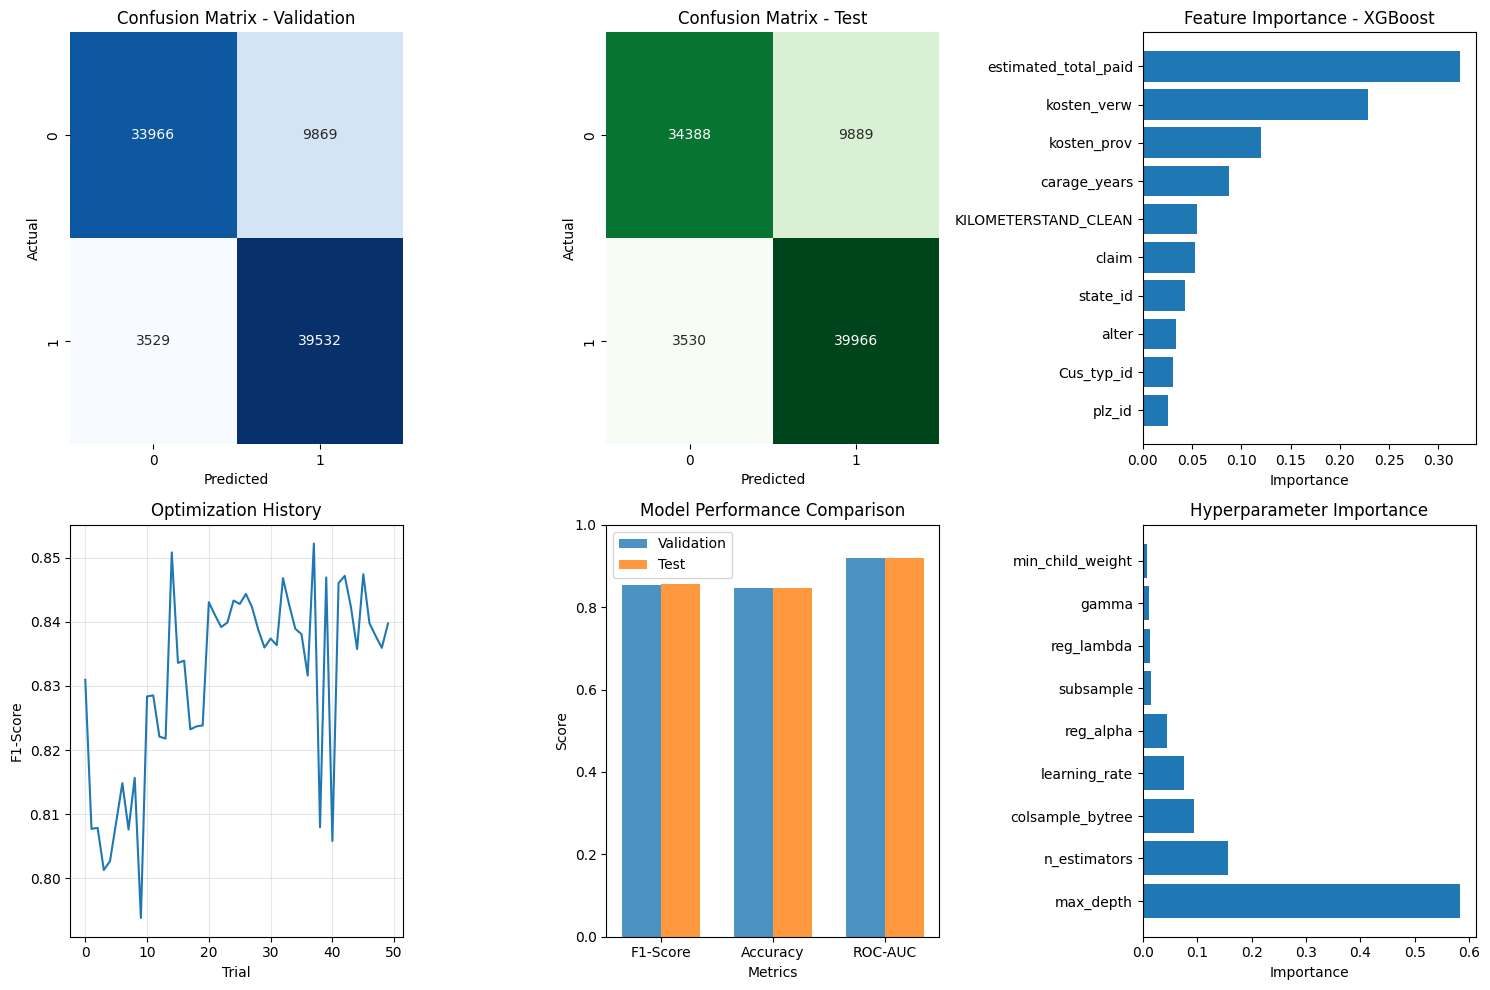


📋 FINAL SUMMARY REPORT
🎯 Best Hyperparameters Found:
   n_estimators: 362
   max_depth: 8
   learning_rate: 0.17422566579828516
   subsample: 0.7924266515000261
   colsample_bytree: 0.8678643852412511
   gamma: 0.5596327323046584
   reg_alpha: 0.10475160351095458
   reg_lambda: 1.500081672966179
   min_child_weight: 5

📊 Performance Summary:
   Validation F1: 0.8551
   Test F1:       0.8563
   Validation AUC: 0.9185
   Test AUC:       0.9188

💾 Model saved as: enhanced_tuned_xgboost_model.pkl
🎉 Training completed successfully!
📊 Study results saved as: optuna_study_results.pkl

📈 Results Summary:
      Dataset  F1_Score  Accuracy   ROC_AUC
0  Validation  0.855097  0.845816  0.918454
1        Test  0.856252  0.847117  0.918848
✅ Part 4 completed! All visualizations and reports generated.


In [9]:
# PART 4: VISUALIZATIONS AND FINAL REPORT
# Run this after Part 3 is completed

# ✅ 9. Visualizations
plt.figure(figsize=(15, 10))

# Confusion Matrix - Validation
plt.subplot(2, 3, 1)
cm_val = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Validation")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Confusion Matrix - Test
plt.subplot(2, 3, 2)
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Feature Importance
plt.subplot(2, 3, 3)
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

plt.barh(range(len(importance_df)), importance_df['Importance'])
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")

# Optuna optimization history
plt.subplot(2, 3, 4)
trials_df = study.trials_dataframe()
plt.plot(trials_df['number'], trials_df['value'])
plt.title("Optimization History")
plt.xlabel("Trial")
plt.ylabel("F1-Score")
plt.grid(True, alpha=0.3)

# Performance comparison
plt.subplot(2, 3, 5)
metrics = ['F1-Score', 'Accuracy', 'ROC-AUC']
val_scores = [val_f1, val_accuracy, val_auc]
test_scores = [test_f1, test_accuracy, test_auc]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, val_scores, width, label='Validation', alpha=0.8)
plt.bar(x + width/2, test_scores, width, label='Test', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Parameter importance
plt.subplot(2, 3, 6)
param_importance = optuna.importance.get_param_importances(study)
params = list(param_importance.keys())
importances = list(param_importance.values())

plt.barh(range(len(params)), importances)
plt.yticks(range(len(params)), params)
plt.title("Hyperparameter Importance")
plt.xlabel("Importance")

plt.tight_layout()
plt.show()

# ✅ 10. Summary report
print("\n" + "="*60)
print("📋 FINAL SUMMARY REPORT")
print("="*60)
print(f"🎯 Best Hyperparameters Found:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

print(f"\n📊 Performance Summary:")
print(f"   Validation F1: {val_f1:.4f}")
print(f"   Test F1:       {test_f1:.4f}")
print(f"   Validation AUC: {val_auc:.4f}")
print(f"   Test AUC:       {test_auc:.4f}")

print(f"\n💾 Model saved as: {model_filename}")
print("🎉 Training completed successfully!")

# ✅ 11. Optional: Save study results
study_filename = 'optuna_study_results.pkl'
joblib.dump(study, study_filename)
print(f"📊 Study results saved as: {study_filename}")

# Create results dataframe for future analysis
results_df = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'F1_Score': [val_f1, test_f1],
    'Accuracy': [val_accuracy, test_accuracy],
    'ROC_AUC': [val_auc, test_auc]
})

print(f"\n📈 Results Summary:")
print(results_df)

print("✅ Part 4 completed! All visualizations and reports generated.")